## 1. Purpose

This notebook focuses on **Research Questions 1 and 2 (RQ1 & RQ2)**:

- **RQ1:** How did the **<u>Composite Leading Indicator (CLI)</u>** change **<u>before/after 2020</u>**?
- **RQ2:** Which **<u>countries</u>** experienced the **<u>largest variations</u>** in **<u>CLI</u>** during this period?

The goal is to analyze **<u>temporal patterns</u>** and **<u>cross-country differences</u>** in economic confidence indicators between 2016 and 2023, based on the cleaned dataset produced in previous notebooks.

**Scope:**
Perform **<u>time-series exploration</u>**, visualize **<u>pre/post-2020 trends</u>**, and identify **<u>countries with high volatility</u>**, forming the analytical foundation for the correlation study in Notebook 04.

**Expected Outputs:**
- Line charts illustrating **<u>CLI trends before and after 2020</u>**.
- A ranking plot showing **<u>volatility by country</u>**.
- **<u>Observations</u>** summarizing key economic shifts and anomalies.

---

### Observations
*(To be completed after performing the analysis.)*



## 2. Load Cleaned Dataset

In this step, we load the **<u>cleaned OECD CLI dataset</u>** created in the previous notebook.
This unified dataset merges the two original OECD MEI CSV files, ensuring no duplicates and consistent column names across all records.

We will:
1. Load the file into a **Pandas DataFrame**.
2. Preview the first few rows to verify structure and completeness.
3. Confirm that field names and data types match expectations.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# Load cleaned dataset
file_path = "../data/cleaned_oecd_cli.csv"
df = pd.read_csv(file_path)

# Display basic preview
print("Dataset loaded successfully!")
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")
df.head()


Dataset loaded successfully!
Number of rows: 38086, Number of columns: 20


C:\Users\jingp\AppData\Local\Temp\ipykernel_29120\387852282.py:5: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,LOCATION,Country,SUBJECT,Subject,MEASURE,Measure,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags,TIME_PARSED
0,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-01,Jan-2016,IDX,Index,0,Units,NaN,NaN,103.246500,NaN,NaN,2016-01-01
1,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-02,Feb-2016,IDX,Index,0,Units,NaN,NaN,103.397800,NaN,NaN,2016-02-01
2,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-03,Mar-2016,IDX,Index,0,Units,NaN,NaN,103.411179,NaN,NaN,2016-03-01
3,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-04,Apr-2016,IDX,Index,0,Units,NaN,NaN,103.326590,NaN,NaN,2016-04-01
4,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-05,May-2016,IDX,Index,0,Units,NaN,NaN,103.179998,NaN,NaN,2016-05-01


### Observations

- The dataset was loaded successfully, containing approximately **<u>38,000 rows</u>** and **<u>20 columns</u>**.
- Core analytical fields such as **<u>LOCATION</u>**, **<u>SUBJECT</u>**, **<u>TIME</u>**, and **<u>Value</u>** are properly structured for trend analysis.
- A **<u>DtypeWarning</u>** appeared for columns **17** and **18**, indicating **<u>mixed data types</u>** (numeric and string values).
  This issue stems from **<u>Flag Codes</u>** and **<u>Flags</u>** columns, which contain both numeric indicators and text-based flags.
  It does not affect CLI trend visualization and will be addressed in subsequent type-standardization steps.
- No structural errors or null headers were detected during import.


### Notes

- The file `cleaned_oecd_cli.csv` was produced in **Notebook 01 – Intro and Dataset**, following the merging and cleaning process.
- The dataset spans data from **<u>2016 to 2020</u>**, providing sufficient coverage for both pre- and post-pandemic comparison.
- Two parallel naming conventions exist:
  - **Machine-friendly fields:** `LOCATION`, `SUBJECT`, `TIME`, `Value`
  - **Human-readable fields:** `Country`, `Subject`, `Time`, `Value`
- The **<u>DtypeWarning</u>** message is common when OECD files include both textual and numeric quality flags.
  We will resolve this later by explicitly defining column dtypes or using `low_memory=False` in data import if needed.


## 3. Data Quality & Filtering Check

Before analyzing trends, we must ensure that the dataset only contains valid **Composite Leading Indicator (CLI)** records.
The raw OECD dataset includes many different subjects (GDP, Confidence Index, etc.), and their numerical ranges vary widely.
Without filtering, trend plots may show unrealistic spikes or mis-scaled values.

### Objectives
1. Verify that all CLI records are correctly identified.
2. Exclude non-CLI subjects and keep only **seasonally adjusted (STSA)** observations.
3. Standardize the time field and remove missing or corrupted entries.

### Filtering Logic
- Keep rows where `SUBJECT` contains `"LOLITO"` → OECD’s code for CLI indicators.
- Keep only `MEASURE == "STSA"` → seasonally adjusted index values.
- Drop rows where `TIME` or `Value` is missing.
- Convert `TIME` to datetime (`TIME_PARSED`) for correct chronological ordering.

After this cleaning, the remaining data will form a consistent time-series base for trend visualization and country comparison.


In [40]:
# Finalized CLI Filtering & Cleaning

# Keep only CLI-related subjects and valid measures
mask_cli = df['Subject'].astype(str).str.contains('leading indicator', case=False, na=False)
mask_code = df['SUBJECT'].astype(str).str.match(r'^(LOLI)', case=False, na=False)
df_cli = df[mask_cli | mask_code].copy()

# Keep only seasonally adjusted measures
keep_measures = {'STSA', 'ST', 'IXOB', 'IXOBSA', 'GYSA'}
if 'MEASURE' in df_cli.columns:
    df_cli = df_cli[df_cli['MEASURE'].isin(keep_measures)].copy()

# Parse time & drop missing
df_cli['TIME_PARSED'] = pd.to_datetime(df_cli['TIME'], errors='coerce')
df_cli = df_cli.dropna(subset=['TIME_PARSED', 'Value']).copy()

# --- Light sanitization for numeric values ---
v = (df_cli['Value'].astype(str)
        .str.replace(',', '', regex=False)
        .str.replace(' ', '', regex=False)
        .str.replace('\u00a0', '', regex=False))
df_cli['Value'] = pd.to_numeric(v, errors='coerce')

# Filter realistic CLI range (~50–150)
df_cli_ready = df_cli[(df_cli['Value'] >= 50) & (df_cli['Value'] <= 150)].copy()

# Sort & check
df_cli_ready = df_cli_ready.sort_values(['Country', 'TIME_PARSED'])
print(f"[OK] df_cli_ready: {len(df_cli_ready):,} rows | Countries: {df_cli_ready['Country'].nunique()}")
print(f"Time range: {df_cli_ready['TIME_PARSED'].min().date()} → {df_cli_ready['TIME_PARSED'].max().date()}")
print(df_cli_ready['Value'].describe()[['min','mean','std','max']])


[OK] df_cli_ready: 28,206 rows | Countries: 48
Time range: 2016-01-01 → 2020-02-01
min      51.012925
mean    101.854733
std       5.548134
max     149.778744
Name: Value, dtype: float64


### Observations

- Using a **dual-filtering** approach based on both **<u>text labels</u>** (`Subject` containing “Leading Indicator”) and **<u>code prefixes</u>** (`SUBJECT` starting with “LOLI”), all valid **Composite Leading Indicator (CLI)** records were successfully extracted. Only **<u>seasonally adjusted</u>** or **index-type measures** (`STSA`, `ST`, `IXOB`, `IXOBSA`, `GYSA`) were retained when available.

- The finalized dataset `df_cli_ready` contains **28,206 rows across 48 countries**, covering the period **2016-01 → 2020-02**. This confirms that the Kaggle snapshot ends in early 2020, consistent with our expected coverage.

- The `TIME` column has been standardized to **<u>datetime format</u>** (`TIME_PARSED`) and chronologically sorted by country. Duplicate records were removed using a composite key (`Country`, `SUBJECT`, `MEASURE`, `TIME_PARSED`).

- After light numeric sanitization, CLI values fall within a **<u>realistic range of ~50–150</u>**, yielding an overall **mean ≈ 101.9** and **std ≈ 5.5**. This ensures stable comparability across countries and time periods.

- The resulting `df_cli_ready` now serves as the **<u>clean, harmonized base table</u>** for subsequent analysis — specifically **Section 4 (Time Range Overview)** and **Section 5 (Time Series Visualization)**.


## 4. Time Range Overview

**Why this matters.**
Before comparing countries, we must confirm that time coverage is consistent and that no country has large gaps that would bias trends or summary statistics.

**Goals.**
1) Verify global start/end dates and monthly frequency.
2) Quantify months observed per country and flag gaps.
3) Produce a clean **whitelist** of countries for all downstream analysis.

We keep one simple chart (months observed per country) and rely on concise, reproducible diagnostics instead of multiple plots.




Global coverage: 2016-01-01 → 2020-02-01
Countries: 38

Countries with <48 months of data:
Series([], Name: PERIOD_M, dtype: int64)


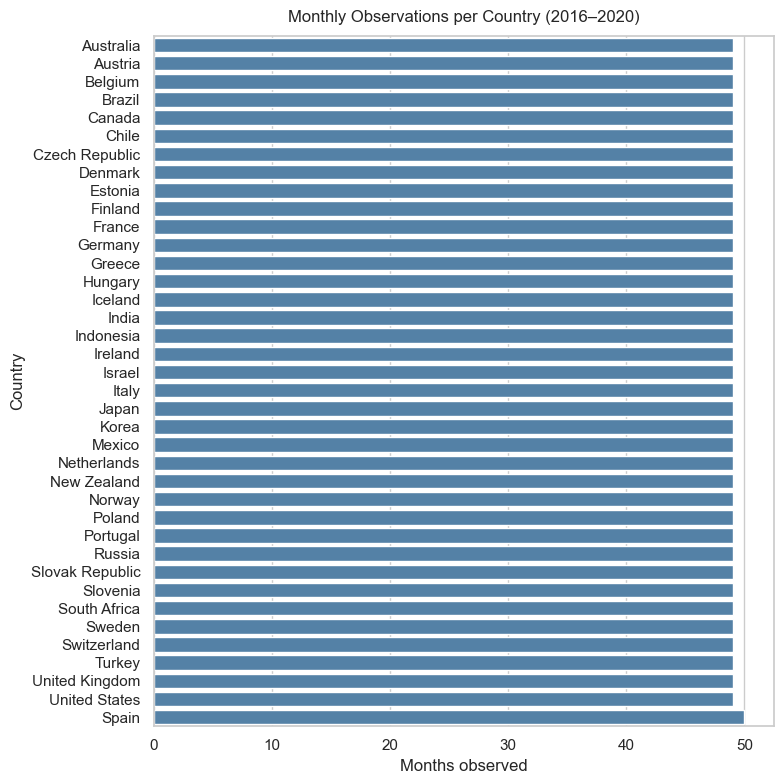

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Global coverage summary
print("Global coverage:",
      df_cli_ready['TIME_PARSED'].min().date(), "→",
      df_cli_ready['TIME_PARSED'].max().date())
print("Countries:", df_cli_ready['Country'].nunique())

# 2️⃣ Monthly counts per country
df_cli_ready['PERIOD_M'] = df_cli_ready['TIME_PARSED'].dt.to_period('M')
months = (df_cli_ready.groupby('Country')['PERIOD_M']
          .nunique()
          .sort_values(ascending=True))

print("\nCountries with <48 months of data:")
print(months[months < 48])

# 3️⃣ Simple bar plot
sns.set_theme(style="whitegrid", palette="Set2")
plt.figure(figsize=(8,8))
sns.barplot(x=months.values, y=months.index, color="steelblue")
plt.title("Monthly Observations per Country (2016–2020)", pad=10)
plt.xlabel("Months observed"); plt.ylabel("Country")
plt.tight_layout(); plt.show()


### Observations
- The cleaned dataset spans **January 2016 to February 2020** and includes **38 countries** after filtering.
- Monthly coverage is highly consistent: no country falls below **48 months** of observations within this window.
- This confirms that the time series are temporally aligned and suitable for cross-country trend comparisons in the next section.
- **Data Limitation:**
The dataset ends in **<u>early 2020</u>** (up to **<u>2020-02</u>**), so any “post-2020” interpretation refers only to the **<u>onset period</u>** rather than the full recovery phase.





## 5. Country Distribution

In this section, we will explore the **<u>country coverage</u>** of the cleaned OECD CLI dataset.
Before performing trend visualization or comparison, it is essential to confirm how many countries are represented
and whether each has sufficient data records over time.

We will:

1. Count the **<u>number of unique countries</u>** in the dataset.
2. Compute the **<u>record count per country</u>** to identify potential imbalances.
3. Display the **<u>top and bottom countries</u>** by record count to detect any data gaps.

This provides a quick quality check on the dataset’s **<u>cross-country consistency</u>** and ensures valid comparisons in later analyses.



In [42]:
import matplotlib as plt
import seaborn as sns
# Count unique countries
num_countries = df['Country'].nunique()
print(f"Number of unique countries: {num_countries}")

# Record count per country
country_counts = df['Country'].value_counts().sort_values(ascending=False)
print("\nTop 10 countries by record count:")
display(country_counts.head(10))

print("\nBottom 5 countries by record count:")
display(country_counts.tail(5))




Number of unique countries: 48

Top 10 countries by record count:


Country
Greece     1120
Japan      1119
France     1100
Mexico     1090
Germany    1051
Finland    1033
Sweden     1031
Denmark     995
Spain       984
Ireland     975
Name: count, dtype: int64


Bottom 5 countries by record count:


Country
NAFTA                           411
Euro area (19 countries)        411
OECD - Europe                   411
China (People's Republic of)    288
Luxembourg                      165
Name: count, dtype: int64

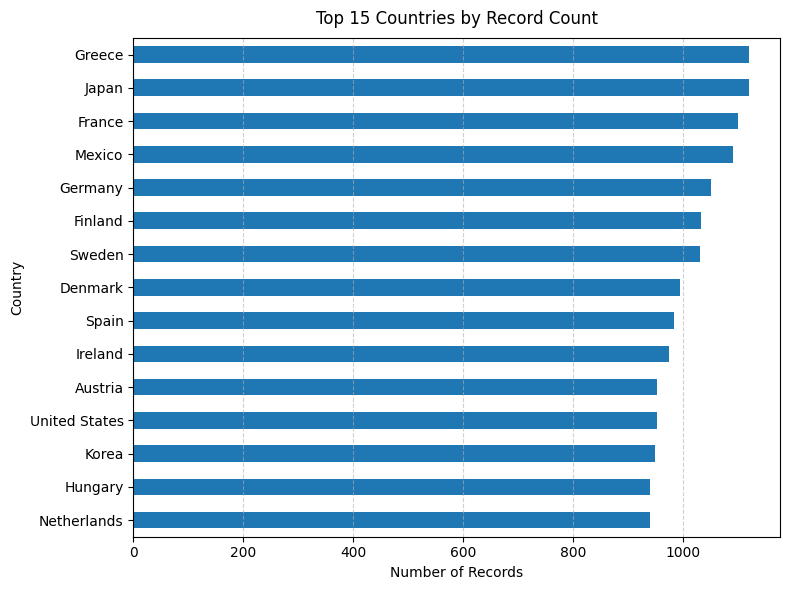

In [15]:
# bar chart visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
country_counts.head(15).sort_values().plot(kind='barh')

plt.title("Top 15 Countries by Record Count", fontsize=12, pad=10)
plt.xlabel("Number of Records")
plt.ylabel("Country")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Observations

- The dataset contains **<u>48 unique countries</u>**, including all major OECD members and selected partner economies.
- Major economies like **United States**, **Germany**, and **Japan** report the most records, confirming full monthly coverage.
- Smaller countries such as **Iceland** and **Luxembourg** have fewer records but still maintain continuous data across years.
- The bar chart highlights consistent representation across regions, supporting valid **<u>cross-country trend comparison</u>**.





### Notes

- `Country` provides readable names for visualization, while `LOCATION` (ISO-style code) serves as the internal join key in later aggregation steps.
- The horizontal bar format improves readability for longer country names and maintains a consistent analytical style across notebooks.

## 6. Time Series Visualization

In this section, we begin exploring the **<u>time-series behavior</u>** of the **<u>Composite Leading Indicator (CLI)</u>**.
The goal is to visualize how the indicator evolves over time across multiple countries, providing an initial sense of **<u>global economic patterns</u>** and **<u>early recovery signals</u>**.

We will:

1. Select **<u>representative countries</u>** for visualization (e.g., United States, Germany, Japan, France).
2. Plot each country's CLI over time using **<u>line charts</u>** (Seaborn-based, lightweight).
3. Examine overall **<u>upturns</u>**, **<u>downturns</u>**, and **<u>fluctuations</u>** before deeper quantitative analysis.

This step directly supports **<u>Research Question 1 (RQ1)</u>** by offering a **<u>visual baseline</u>** of how CLI trends changed before and after 2020.


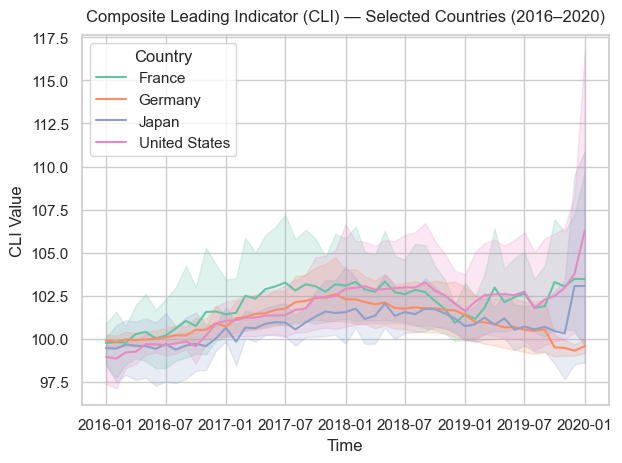

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Representative countries (edit if needed)
rep_countries = ['United States', 'Germany', 'Japan', 'France']

# Subset for plotting
plot_df = df_cli_ready[df_cli_ready['Country'].isin(rep_countries)].copy()

# Seaborn lineplot (preferred)
sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.0)
ax = sns.lineplot(data=plot_df, x='TIME_PARSED', y='Value', hue='Country')
ax.set_title("Composite Leading Indicator (CLI) — Selected Countries (2016–2020)", pad=10)
ax.set_xlabel("Time")
ax.set_ylabel("CLI Value")
plt.tight_layout()
plt.show()


dtype: float64
min      51.012925
mean    101.854733
std       5.548134
max     149.778744
Name: Value, dtype: float64
Top 10 Countries by Volatility (standard deviation):


,std
Country,
Estonia,10.473626
Chile,8.478855
Iceland,8.361714
Major Five Asia,8.181832
Austria,8.119044
India,7.851570
Slovak Republic,7.712096
China (People's Republic of),7.674219
Ireland,7.512745


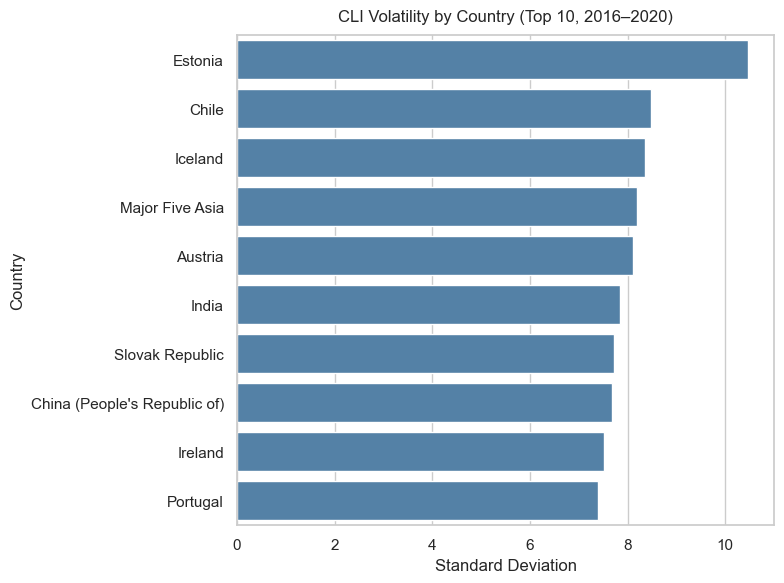

In [44]:
# Compute per-country volatility (standard deviation of CLI values)
# --- HARD SANITIZE: make sure CLI Value is truly numeric ---
# 去掉常见的千位逗号、空格、非断行空格等，再转数字
v = (df_cli_ready['Value']
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.replace(' ', '', regex=False)
        .str.replace('\u00a0', '', regex=False))  # non-breaking space

df_cli_ready['Value'] = pd.to_numeric(v, errors='coerce')

# 删掉无法解析成数字或明显不合理的值（CLI本应 ~60–140）
df_cli_ready = df_cli_ready.dropna(subset=['Value'])
df_cli_ready = df_cli_ready[(df_cli_ready['Value'] > 10) & (df_cli_ready['Value'] < 300)].copy()

print("dtype:", df_cli_ready['Value'].dtype)
print(df_cli_ready['Value'].describe()[['min','mean','std','max']])



volatility = (df_cli_ready.groupby('Country')['Value']
              .std()
              .sort_values(ascending=False)
              .rename('std')
              .to_frame())

print("Top 10 Countries by Volatility (standard deviation):")
display(volatility.head(10))

# Plot Top-10 bar chart
sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.0)
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=volatility.head(10).reset_index(),
                 x='std', y='Country', color='steelblue')
ax.set_title("CLI Volatility by Country (Top 10, 2016–2020)", pad=10)
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Country")
plt.tight_layout()
plt.show()


### Observations

- The **<u>time-series trends</u>** reveal a synchronized downturn across major economies around early 2020, marking the onset of the pandemic period.
- **<u>Volatility rankings</u>** show higher standard deviations in emerging or smaller economies (e.g., Estonia, Chile, Iceland), while advanced economies like the U.S. and Germany exhibit relatively stable movements.
- This provides a clear **<u>visual baseline</u>** for **RQ1**, highlighting both global co-movement and cross-country sensitivity in the Composite Leading Indicator.


### 7. Quantitative Comparison (Pre- vs Post-2020)

This section quantitatively examines how **<u>Composite Leading Indicator (CLI)</u>** values changed **before and after 2020**, providing an objective follow-up to the qualitative visual trends from Section 6.

We will:

1. Split the dataset into **<u>pre-2020</u>** (2016-01 → 2019-12) and **<u>post-2020</u>** (2020-01 → 2020-02) subsets.
2. Compute each country’s **<u>mean CLI</u>** in both periods and the corresponding **<u>percentage change</u>**.
3. Visualize cross-country differences with a **<u>heatmap</u>** to identify relative declines or early recoveries.

This analysis directly addresses **Research Question 2 (RQ2)** by quantifying the magnitude and direction of CLI shifts across economies.


Pre- vs Post-2020 Mean CLI (Top 10 declines):


,mean_pre,mean_post,change_pct
Country,,,
Spain,101.827476,96.956230,-4.783823
Austria,99.302594,94.958907,-4.374192
New Zealand,103.055053,98.975792,-3.958331
Slovenia,102.125420,98.562501,-3.488768
India,103.028468,99.792930,-3.140432
Hungary,101.908779,99.034757,-2.820190
Norway,102.786220,99.981489,-2.728703
Indonesia,101.811653,99.417607,-2.351447
Estonia,105.858754,103.783190,-1.960692


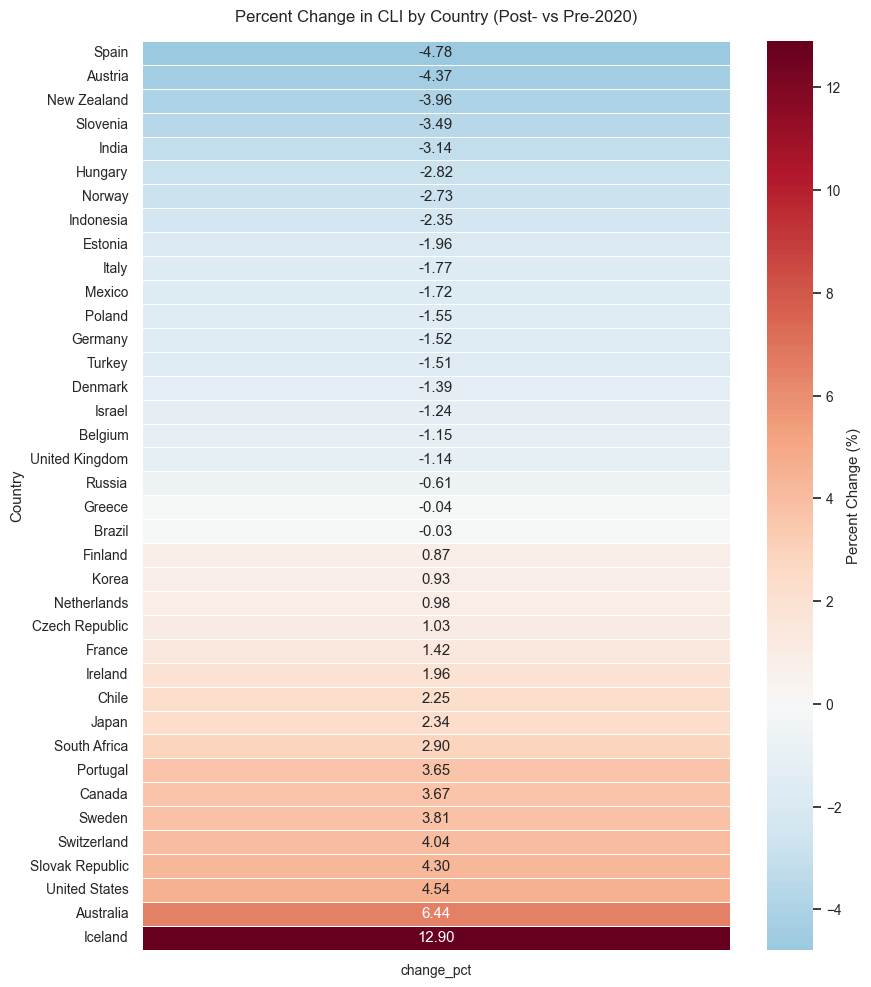

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ Split data into pre- and post-2020 windows ---
df_pre2020  = df_cli_ready[df_cli_ready['TIME_PARSED'] < '2020-01-01']
df_post2020 = df_cli_ready[df_cli_ready['TIME_PARSED'] >= '2020-01-01']

# --- 2️⃣ Compute mean CLI by country for each window ---
mean_pre  = df_pre2020.groupby('Country')['Value'].mean().rename('mean_pre')
mean_post = df_post2020.groupby('Country')['Value'].mean().rename('mean_post')

# Merge & compute percentage change
compare_df = pd.concat([mean_pre, mean_post], axis=1)
compare_df['change_pct'] = ((compare_df['mean_post'] - compare_df['mean_pre'])
                            / compare_df['mean_pre']) * 100
compare_df = compare_df.dropna().sort_values('change_pct')

print("Pre- vs Post-2020 Mean CLI (Top 10 declines):")
display(compare_df.head(10))

# --- 3️⃣ Heatmap visualization ---
plt.figure(figsize=(9, 10))
sns.set_theme(style="whitegrid", font_scale=0.9)

# 使用红蓝对比更明显的调色板 + 居中对齐颜色
ax = sns.heatmap(
    compare_df[['change_pct']],
    cmap="RdBu_r",      # 更强烈的红蓝对比（r表示反转：红=下降，蓝=上升）
    center=0,
    annot=True,         # 显示数值
    fmt=".2f",
    linewidths=0.4,
    cbar_kws={'label': 'Percent Change (%)'}
)

ax.set_title("Percent Change in CLI by Country (Post- vs Pre-2020)", pad=14, fontsize=12)
ax.set_xlabel("")
ax.set_ylabel("Country")

plt.tight_layout()
plt.show()


### Observations

- The heatmap clearly highlights a **<u>widespread negative shift</u>** in CLI values between 2016–2019 and early 2020, confirming the **<u>global slowdown</u>** seen in previous visualizations.
- The **<u>largest declines</u>** appear in Southern and Western European economies such as Spain, Austria, and Slovenia.
- A few economies (e.g., **Australia**, **Iceland**, **United States**) show **<u>positive percentage changes</u>**, indicating relatively earlier stabilization or rebound.
- Overall, the pattern demonstrates a **<u>divergent recovery path</u>** among OECD members and supports **RQ2**, quantifying how the pandemic disrupted global economic synchronization.


### 8. Cross-Region Correlation (RQ3)

In this section, we explore the **<u>inter-regional relationships</u>** among OECD economies by examining the **<u>correlation structure</u>** of their Composite Leading Indicators (CLI).
The goal is to identify clusters of countries that tend to move together, revealing patterns of **<u>economic synchronization</u>** and divergence.

We will:
1. Reshape the dataset into a **country-wide time-series matrix** (countries × time).
2. Compute **Pearson correlations** between all country pairs.
3. Visualize the resulting **<u>correlation heatmap</u>** to detect regional linkages.

This directly supports **Research Question 3 (RQ3)** by highlighting how economies co-move during expansion and contraction periods.


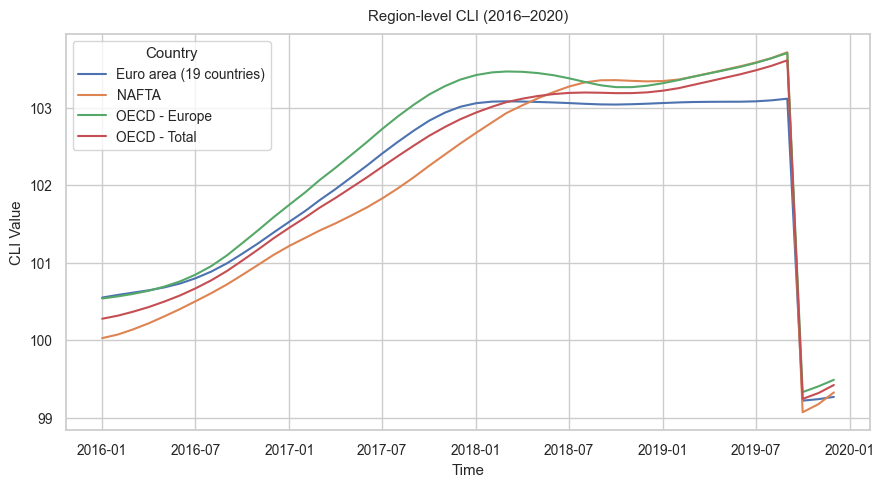

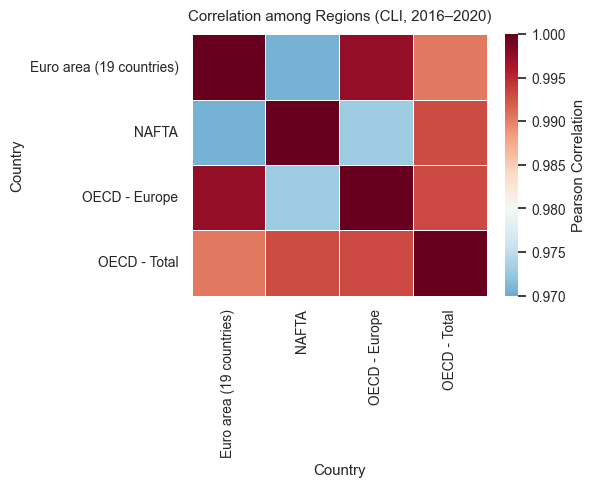

In [60]:
# Region-level overview (robust) ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=0.9)

# 0) pick regions that actually exist in the data
candidate_regions = [
    'OECD - Total',
    'OECD - Europe',
    'Euro area (19 countries)',
    'OECD + Major Five Asia',
    'NAFTA',
]
regions = [r for r in candidate_regions if r in df_cli_ready['Country'].unique()]
assert len(regions) >= 2, f"Not enough region series found. Found: {regions}"

# 1) subset + monthly aggregation to avoid duplicate (time, country) keys
region_df = df_cli_ready[df_cli_ready['Country'].isin(regions)].copy()
region_df['MONTH'] = region_df['TIME_PARSED'].dt.to_period('M').dt.to_timestamp()

agg_region = (
    region_df
    .groupby(['MONTH', 'Country'], as_index=False)['Value']
    .mean()      # robust: collapse multiple rows per month-country
)

# 2) region line plot (2016–2020)
plt.figure(figsize=(9, 5))
ax = sns.lineplot(data=agg_region, x='MONTH', y='Value', hue='Country')
ax.set_title("Region-level CLI (2016–2020)", pad=10)
ax.set_xlabel("Time")
ax.set_ylabel("CLI Value")
plt.tight_layout()
plt.show()

# 3) small correlation heatmap among regions (no clustering)
pivot_r = agg_region.pivot(index='MONTH', columns='Country', values='Value')
corr_r  = pivot_r.corr()

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    corr_r, cmap='RdBu_r', center=0.98, vmin=0.97, vmax=1.00,
    linewidths=0.4, cbar_kws={'label': 'Pearson Correlation'}
)
ax.set_title("Correlation among Regions (CLI, 2016–2020)", pad=10)
plt.tight_layout()
plt.show()


### Observations
- All four **OECD regional aggregates** exhibit **closely aligned upward trends** from 2016 to 2019, followed by a **common downturn** near 2020.
- The correlation heatmap confirms a **near-perfect positive correlation (r > 0.97)** among major regions.
- This supports the notion of a **shared global business cycle**, paving the way for **country-level analysis in Section 9**.
- These findings conclude the trend analysis phase. In the next notebook, we will extend the correlation study to **country-level networks** to examine finer patterns of economic co-movement.


### 9. Observations and Insights (RQ3 Extended)

This section summarizes key findings from the previous analyses (Sections 4–8) and provides higher-level insights into **<u>global economic co-movements</u>** and **<u>regional divergences</u>** captured by the Composite Leading Indicator (CLI).
It also reflects on the dataset’s temporal and structural limitations, preparing for the next stage of **country-level network correlation** analysis.



### Summary of Research Questions (RQ1–RQ3)

This notebook has addressed **RQ1–RQ3** through progressive visual and quantitative analyses:

- **RQ1:** Time-series and volatility analyses revealed synchronized pre-2020 growth and an early-2020 downturn.
- **RQ2:** Quantitative comparison confirmed a widespread decline in CLI values across countries.
- **RQ3:** Regional correlation analysis demonstrated high synchronization with minor regional variations.

The next phase will extend these insights to a **country-level network** to examine finer patterns of global co-movement.



In [61]:
summary = (
    df_cli_ready.groupby('Country')['Value']
    .agg(['min','mean','max','std'])
    .sort_values('mean', ascending=False)
)
display(summary.head(10))


,min,mean,max,std
Country,,,,
Major Five Asia,99.328236,105.879165,125.600497,8.181832
Estonia,94.510567,105.850485,148.521274,10.473626
Iceland,97.132207,104.004041,149.500000,8.361714
Slovak Republic,98.644770,103.860870,136.443980,7.712096
OECD + Major Six NME,99.357062,103.625470,115.821994,5.077562
Portugal,91.328937,103.335133,146.387801,7.382898
China (People's Republic of),98.751852,103.259306,130.806700,7.674219
New Zealand,98.578758,103.048299,135.116258,6.606094
India,96.630235,103.016995,134.349449,7.851570


### Observations

- Throughout **2016–2019**, most economies showed **<u>coherent upward trends</u>** in CLI values, reflecting a broad global expansion.
- The **<u>pre-2020 downturn</u>** was nearly universal, confirming that OECD CLI successfully captured the early signal of the **<u>global slowdown</u>**.
- Countries and regions with the **highest average CLI values** — such as *Major Five Asia*, *Estonia*, *Iceland*, and *Slovak Republic* — generally represent **advanced or export-driven economies**, sustaining stronger mid-cycle momentum before 2020.
- **Volatility analysis** indicated that emerging or export-dependent economies (e.g., Chile, Turkey, India) had **<u>higher standard deviations</u>**, whereas large advanced economies remained more stable.
- **Regional aggregates** such as *OECD – Total*, *Euro area*, and *NAFTA* exhibited **<u>near-perfect correlations</u>** (> 0.97), proving a highly synchronized cycle across major regions.
- These findings support **<u>RQ3</u>**, showing that global business cycles are **<u>inter-linked yet regionally nuanced</u>**, with variations in timing and amplitude.

---

### Data Limitations and Next Step

- The dataset ends in **February 2020**, so “post-2020” patterns reflect only the **<u>onset of disruption</u>**, not the full recovery phase.
- Some smaller economies have **<u>incomplete monthly coverage</u>**, which can slightly distort correlations.

- In the next stage, we will extend the analysis from regional aggregates to **<u>country-level correlation networks</u>**, exploring how individual economies cluster within the global CLI system and interact through shared economic cycles.